In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multioutput import MultiOutputClassifier

# ---- GPU-capable LightGBM
from lightgbm import LGBMClassifier

In [ ]:
train_path = "/content/drive/MyDrive/train_test_data/train_encoded.csv"
test_path  = "/content/drive/MyDrive/train_test_data/train_encoded.csv"


train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

In [ ]:
TARGETS = ["Genetic Disorder", "Disorder Subclass"]

In [ ]:
X_train = train_df.drop(columns=TARGETS)
Y_train = train_df[TARGETS].copy()

In [ ]:
X_test  = test_df.copy()

In [ ]:
numeric_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_cols)],
    remainder="passthrough"
)

In [ ]:
def make_lgbm(gpu_first: bool = True) -> LGBMClassifier:
    """
    Try GPU (device_type='gpu'); if it fails at fit time,
    catch the exception and recreate a CPU model seamlessly.
    """
    common = dict(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.0,
        reg_lambda=0.0,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    if gpu_first:
        return LGBMClassifier(
            device_type="gpu",      # <<< use GPU
            max_bin=255,            # good default for GPU hist
            **common
        )
    else:
        return LGBMClassifier(device_type="cpu", **common)

In [ ]:
base_lgb = make_lgbm(gpu_first=True)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def evaluate_target(target_name: str):
    y = Y_train[target_name]

    # Try GPU; if it fails, switch to CPU and continue
    clf_try = base_lgb
    pipe = Pipeline([("prep", preprocessor), ("clf", clf_try)])
    try:
        y_pred_oof  = cross_val_predict(pipe, X_train, y, cv=cv, method="predict", n_jobs=-1)
        y_proba_oof = cross_val_predict(pipe, X_train, y, cv=cv, method="predict_proba", n_jobs=-1)
        using_gpu = getattr(pipe.named_steps["clf"], "get_params")().get("device_type", "cpu") == "gpu"
    except Exception as e:
        print(f"[LightGBM GPU unavailable -> falling back to CPU] Reason: {e}")
        pipe = Pipeline([("prep", preprocessor), ("clf", make_lgbm(gpu_first=False))])
        y_pred_oof  = cross_val_predict(pipe, X_train, y, cv=cv, method="predict", n_jobs=-1)
        y_proba_oof = cross_val_predict(pipe, X_train, y, cv=cv, method="predict_proba", n_jobs=-1)
        using_gpu = False

    dev_label = "GPU" if using_gpu else "CPU"
    print(f"\n=== {target_name} — OOF Classification Report (5-fold CV, LGBM {dev_label}, balanced) ===\n")
    print(classification_report(y, y_pred_oof, digits=4, zero_division=0))

    # --- Confusion Matrix
    classes = np.unique(np.concatenate([y.unique(), y_pred_oof]))
    cm = confusion_matrix(y, y_pred_oof, labels=classes)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        ylabel="True label",
        xlabel="Predicted label",
        title=f"Confusion Matrix — {target_name} (OOF, LGBM {dev_label})"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

    # --- ROC (OvR) from OOF probabilities
    if y_proba_oof is not None and y_proba_oof.ndim == 2 and y_proba_oof.shape[1] >= 2:
        # Fit once to get class order (legend only)
        pipe.fit(X_train, y)
        cls_order = pipe.named_steps["clf"].classes_

        fig = plt.figure(figsize=(7, 5))
        for k, cls in enumerate(cls_order):
            from sklearn.metrics import roc_curve, auc
            fpr, tpr, _ = roc_curve((y == cls).astype(int), y_proba_oof[:, k])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, linewidth=2, label=f"{cls} (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves (OvR) — {target_name} (OOF, LGBM {dev_label})")
        plt.legend()
        plt.show()

[LightGBM GPU unavailable -> falling back to CPU] Reason: No OpenCL device found

=== Genetic Disorder — OOF Classification Report (5-fold CV, LGBM CPU, balanced) ===

              precision    recall  f1-score   support

           0     0.6666    0.6862    0.6763      9241
           1     0.3902    0.5285    0.4490      1877
           2     0.5243    0.4535    0.4863      6929

    accuracy                         0.5804     18047
   macro avg     0.5271    0.5560    0.5372     18047
weighted avg     0.5832    0.5804    0.5797     18047



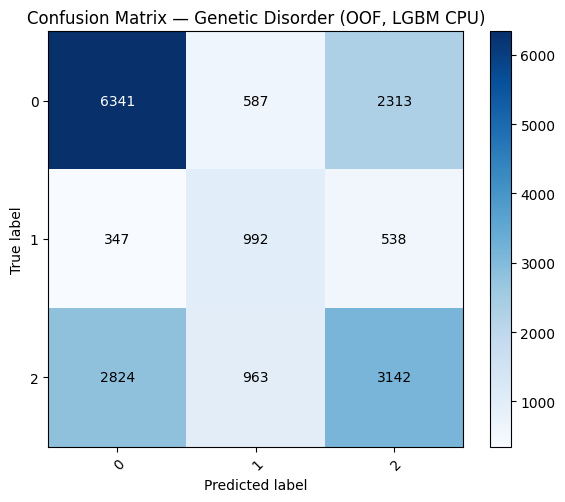

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 18047, number of used features: 37
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


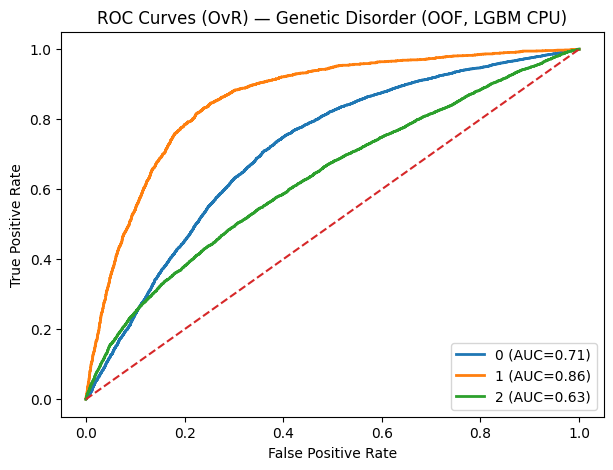

[LightGBM GPU unavailable -> falling back to CPU] Reason: No OpenCL device found

=== Disorder Subclass — OOF Classification Report (5-fold CV, LGBM CPU, balanced) ===

              precision    recall  f1-score   support

           0     0.4333    0.0977    0.1595       133
           1     0.2857    0.0659    0.1071        91
           2     0.4353    0.4741    0.4539      3145
           3     0.3551    0.3158    0.3343      1653
           4     0.3497    0.3306    0.3399      1228
           5     0.3150    0.1857    0.2337       587
           6     0.4190    0.4192    0.4191      4683
           7     0.3587    0.3712    0.3649      3971
           8     0.3264    0.3576    0.3413      2556

    accuracy                         0.3822     18047
   macro avg     0.3643    0.2909    0.3060     18047
weighted avg     0.3810    0.3822    0.3795     18047



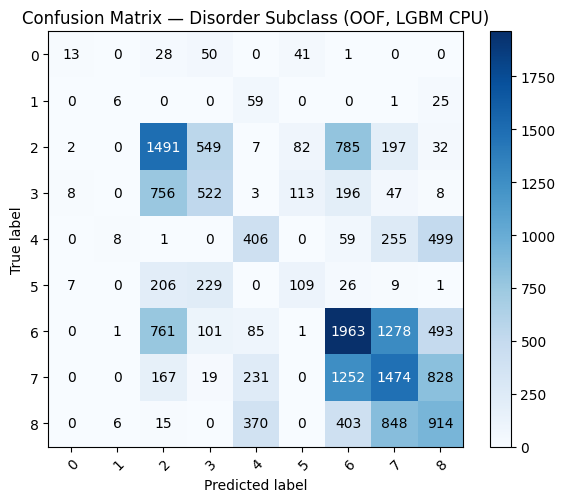

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 18047, number of used features: 37
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

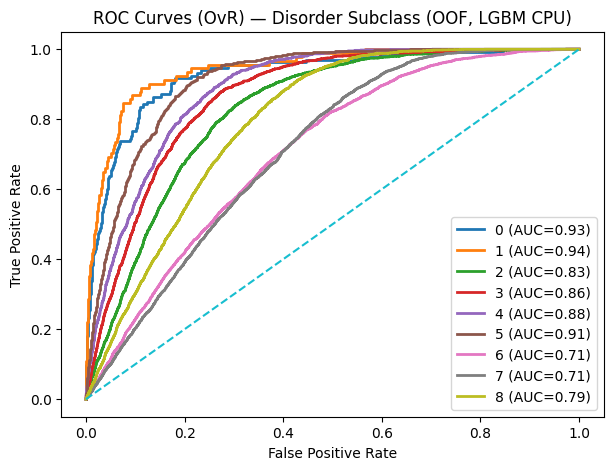

In [ ]:
for tgt in TARGETS:
    evaluate_target(tgt)


OOF summary per target (LGBM, GPU if available):
           target device  accuracy  balanced_accuracy  f1_macro  f1_weighted
 Genetic Disorder    CPU    0.5804             0.5560    0.5372       0.5797
Disorder Subclass    CPU    0.3822             0.2909    0.3060       0.3795

Overall mean accuracy (OOF across targets): 0.4813


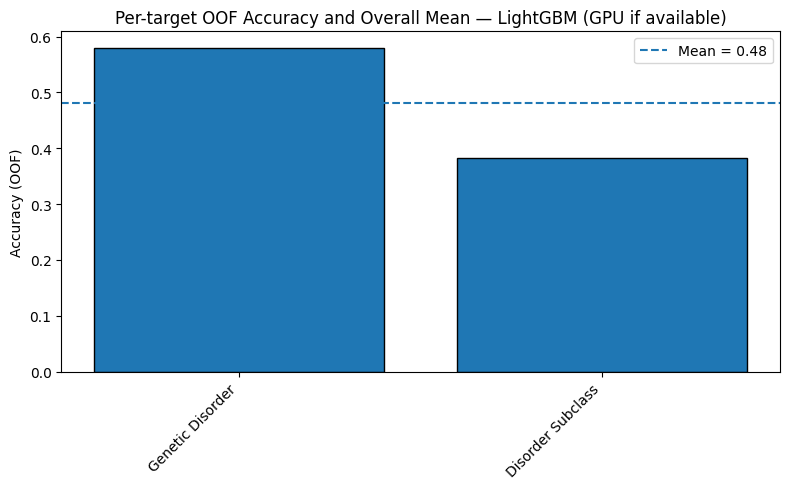

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

per_target_rows = []
for tgt in TARGETS:
    y = Y_train[tgt]
    pipe = Pipeline([("prep", preprocessor), ("clf", base_lgb)])
    try:
        y_pred_oof = cross_val_predict(pipe, X_train, y, cv=cv, method="predict", n_jobs=-1)
        using_gpu = pipe.named_steps["clf"].get_params().get("device_type", "cpu") == "gpu"
    except Exception:
        pipe = Pipeline([("prep", preprocessor), ("clf", make_lgbm(gpu_first=False))])
        y_pred_oof = cross_val_predict(pipe, X_train, y, cv=cv, method="predict", n_jobs=-1)
        using_gpu = False

    acc  = accuracy_score(y, y_pred_oof)
    bacc = balanced_accuracy_score(y, y_pred_oof)
    f1m  = f1_score(y, y_pred_oof, average="macro", zero_division=0)
    f1w  = f1_score(y, y_pred_oof, average="weighted", zero_division=0)
    per_target_rows.append({
        "target": tgt, "device": "GPU" if using_gpu else "CPU",
        "accuracy": acc, "balanced_accuracy": bacc, "f1_macro": f1m, "f1_weighted": f1w
    })

summary_df = pd.DataFrame(per_target_rows).round(4)
print("\nOOF summary per target (LGBM, GPU if available):")
print(summary_df.to_string(index=False))

mean_acc = float(np.mean(summary_df["accuracy"]))
print("\nOverall mean accuracy (OOF across targets): {:.4f}".format(mean_acc))

plt.figure(figsize=(8,5))
plt.bar(summary_df["target"], summary_df["accuracy"], edgecolor="black")
plt.axhline(mean_acc, linestyle="--", label=f"Mean = {mean_acc:.2f}")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy (OOF)")
plt.title("Per-target OOF Accuracy and Overall Mean — LightGBM (GPU if available)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_primary = Y_train["Genetic Disorder"]
pipe_gs = Pipeline([("prep", preprocessor), ("clf", make_lgbm(gpu_first=True))])

In [ ]:
param_grid = {
    "clf__n_estimators": [600, 800, 1000, 1200],
    "clf__num_leaves": [31, 63, 127],
    "clf__max_depth": [-1, 12, 20, 30],
    "clf__min_child_samples": [10, 20, 40],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0],
    "clf__reg_alpha": [0.0, 0.1, 0.5],
    "clf__reg_lambda": [0.0, 0.1, 0.5],
}

In [ ]:
gs = GridSearchCV(
    estimator=pipe_gs,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

In [ ]:
try:
    gs.fit(X_train, y_primary)
    print("\nBest params (Genetic Disorder, macro-F1, LGBM GPU/CPU):", gs.best_params_)
    print("Best CV macro-F1:", round(gs.best_score_, 4))
    best_lgb = LGBMClassifier(
        device_type="gpu",  # try GPU for final model
        n_estimators=gs.best_params_["clf__n_estimators"],
        learning_rate=0.05,
        num_leaves=gs.best_params_["clf__num_leaves"],
        max_depth=gs.best_params_["clf__max_depth"],
        min_child_samples=gs.best_params_["clf__min_child_samples"],
        subsample=gs.best_params_["clf__subsample"],
        colsample_bytree=gs.best_params_["clf__colsample_bytree"],
        reg_alpha=gs.best_params_["clf__reg_alpha"],
        reg_lambda=gs.best_params_["clf__reg_lambda"],
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
except Exception as e:
    print(f"[LightGBM GPU unavailable in GridSearch -> using CPU] Reason: {e}")
    best_lgb = LGBMClassifier(
        device_type="cpu",
        n_estimators=800, learning_rate=0.05, num_leaves=31, max_depth=-1,
        min_child_samples=20, subsample=0.9, colsample_bytree=0.9,
        reg_alpha=0.0, reg_lambda=0.0, class_weight="balanced",
        n_jobs=-1, random_state=42
    )

[LightGBM GPU unavailable in GridSearch -> using CPU] Reason: 
All the 58320 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
58320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py", line 1560, in f